In [1]:
import os
import sys
import json
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

C:\Users\khj_a\AppData\Local\Programs\Python\Python38\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# 미국인의 김치에 대한 후기를 보는 통계 분석

In [2]:
class Preprocessing:
    
    def __init__(self, max_len = 20):
        self.max_len = max_len
        self.PAD = 0
    
    def pad_idx_sequencing(self, q_vec):
        q_len = len(q_vec)
        diff_len = q_len - self.max_len
        if(diff_len>0):
            q_vec = q_vec[:self.max_len]
            q_len = self.max_len
        else:
            pad_vac = [0] * abs(diff_len)
            q_vec += pad_vac

        return q_vec
    
class MakeDataset:                              # 엑셀 파일의 후기의 단어들만 추출하는 클래스
    
    def __init__(self):
        
        self.intent_data_dir = '#2. 테스트 로데이터.xlsx'
        self.prep = Preprocessing()
    
    def tokenize(self, sentence):
        return str(sentence).split()
    
    def tokenize_dataset(self, dataset):
        token_dataset = []
        for data in dataset:
            token_dataset.append(self.tokenize(data))
        return token_dataset
    
    def make_embed_dataset(self, ood = False):
        embed_dataset = pd.read_excel(self.intent_data_dir)
        embed_dataset = embed_dataset["Content"].to_list()
        embed_dataset = self.tokenize_dataset(embed_dataset)

        return embed_dataset  

In [3]:
dataset = MakeDataset()
embed_dataset = dataset.make_embed_dataset()
embed_dataset
# 만들어진 김치 후기에 적힌 단어들.

[['Arrived',
  'several',
  'days',
  'late',
  '(USPS',
  'fault)',
  'and',
  'was',
  'leaking.',
  'Luckily',
  'there',
  'was',
  'enough',
  'juice',
  'left',
  'to',
  'keep',
  'it.',
  "It's",
  'good',
  'kimchi,',
  'but',
  'it',
  'will',
  'never',
  'be',
  'worth',
  '$25',
  '($15',
  'plus',
  '10',
  'for',
  'shipping)',
  'for',
  'such',
  'a',
  'small',
  'amount.'],
 ['Received',
  'with',
  '2-day',
  'delivery',
  'via',
  'USPS',
  'priority',
  'mail.',
  'The',
  'insulated',
  'box',
  'had',
  'freezer',
  'gel',
  'in',
  'it',
  'to',
  'keep',
  'the',
  'kimchi',
  'temperature',
  'stable.',
  'The',
  'flavor',
  'tastes',
  'very',
  'good',
  'with',
  'a',
  'level',
  'of',
  'heat',
  'that',
  'slowly',
  'builds',
  'on',
  'you.',
  'The',
  'only',
  'issue',
  'I',
  'have',
  'is',
  'that',
  'it',
  'is',
  'not',
  'fermented',
  'as',
  'much',
  'as',
  'I',
  'would',
  'like.',
  'It',
  'seems',
  'like',
  'kimchi',
  'is',
  

In [4]:
class EpochLogger(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0
        
    def on_epoch_begin(self, model):
        print("Epoch #{} start".format(self.epoch))

    def on_epoch_end(self, model):
        print("Epoch #{} end".format(self.epoch))
        self.epoch += 1

class MakeEmbed: # 임베딩을 위한 클래스
    
    def __init__(self):
        self.model_dir = "./"
        self.vector_size = 300 
        self.window_size = 3 
        self.workers = 8 
        self.min_count = 2 
        self.iter = 1000 
        self.sg = 1 
        self.model_file = "./data/pretraining/word2vec_skipgram_{}_{}_{}".format(self.vector_size, self.window_size, self.min_count)
        self.epoch_logger = EpochLogger()
        
    def word2vec_init(self): 
        self.word2vec = Word2Vec(size=self.vector_size,
                         window=self.window_size,
                         workers=self.workers,
                         min_count=self.min_count,
                         compute_loss=True,
                         iter=self.iter)
        
    def word2vec_build_vocab(self, dataset): 
        self.word2vec.build_vocab(dataset)
        
    def word2vec_most_similar(self, query):
        print(self.word2vec.most_similar(query))
        
    def word2vec_train(self,embed_dataset, epoch = 0): 
        if(epoch == 0):
            epoch = self.word2vec.epochs + 1
        self.word2vec.train(
            sentences=embed_dataset,
            total_examples=self.word2vec.corpus_count,
            epochs=epoch,
            callbacks=[self.epoch_logger]
        )

        self.word2vec.save(self.model_file + '.gensim')
        self.vocab = self.word2vec.wv.index2word
        self.vocab = {word: i for i, word in enumerate(self.vocab)}

    def load_word2vec(self):

        if not os.path.exists(self.model_file+'.gensim'):
            raise Exception("모델 로딩 실패 "+ self.model_file+'.gensim')

  
        self.word2vec = Word2Vec.load(self.model_file+'.gensim')
        self.vocab = self.word2vec.wv.index2word
        self.vocab.insert(0,"<UNK>") 
        self.vocab.insert(0,"<PAD>") 
        self.vocab = {word: i for i, word in enumerate(self.vocab)}
        
    def query2idx(self, query):
        sent_idx = []

        for word in query:
            if(self.vocab.get(word)):
                idx = self.vocab[word]
            else:
                idx = 1

            sent_idx.append(idx)

        return sent_idx

In [5]:
embed = MakeEmbed()

embed.word2vec_init()

embed.word2vec.build_vocab(embed_dataset) # 임베딩을 위한 단어장.

C:\Users\khj_a\AppData\Local\Programs\Python\Python38\lib\site-packages\gensim\models\base_any2vec.py:322: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  warnings.warn(


In [6]:
import nltk
from wordcloud import WordCloud

In [7]:
import numpy as np

embed_dataset1 = np.concatenate(embed_dataset).tolist()
embed_dataset1 = " ".join(embed_dataset1)
# 이중 리스트화 된 것을 텍스트화 시키기 위한 과정

In [8]:
wordcloud = WordCloud().generate(embed_dataset1)
print(wordcloud.words_) # 워드 클라우드를 이용한 김치에 대한 후기 단어 비중

{'kimchi': 1.0, 'taste': 0.4211807668898357, 'good': 0.38283627510651247, 'spicy': 0.23189287888009738, 'product': 0.202069385270846, 'flavor': 0.2014607425441266, 'love': 0.1704199634814364, 'delicious': 0.155203895313451, '_x000D_ _x000D_': 0.1472915398660986, 'jar': 0.14059646987218502, 'eat': 0.13755325623858794, 'one': 0.1357273280584297, 's': 0.12720632988435787, 'will': 0.1162507608034084, 'cabbage': 0.11320754716981132, 'buy': 0.10894704808277542, 'really': 0.101034692635423, 'make': 0.09920876445526476, 'fresh': 0.09251369446135119, 'order': 0.08703590992087644, 'try': 0.08703590992087644, 'great': 0.08581862446743761, 'much': 0.08399269628727937, 'bag': 0.08399269628727937, 'price': 0.08399269628727937, 'sour': 0.08094948265368229, 'time': 0.07973219720024345, 'best': 0.07912355447352404, 'day': 0.07851491174680462, '_x000D_': 0.07851491174680462, 'ordered': 0.0772976262933658, 'little': 0.07547169811320754, 'shipping': 0.07303712720632989, 'still': 0.07242848447961046, 'got'

In [9]:
from wordcloud import STOPWORDS

In [10]:
spwords = set(STOPWORDS) # 필요없는 단어를 제거하기 위한 stopwords 지정
spwords

{'_x000D_ _x000D_',
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'all',
 'also',
 'am',
 'an',
 'and',
 'any',
 'are',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 "can't",
 'cannot',
 'com',
 'could',
 "couldn't",
 'did',
 "didn't",
 'do',
 'does',
 "doesn't",
 'doing',
 "don't",
 'down',
 'during',
 'each',
 'else',
 'ever',
 'few',
 'for',
 'from',
 'further',
 'get',
 'had',
 "hadn't",
 'has',
 "hasn't",
 'have',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'hence',
 'her',
 'here',
 "here's",
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 "how's",
 'however',
 'http',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'k',
 "let's",
 'like',
 'me',
 'more',
 'most',
 "mustn't",
 'my',
 'myself',
 'no',
 'nor',
 'not',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'otherwise',

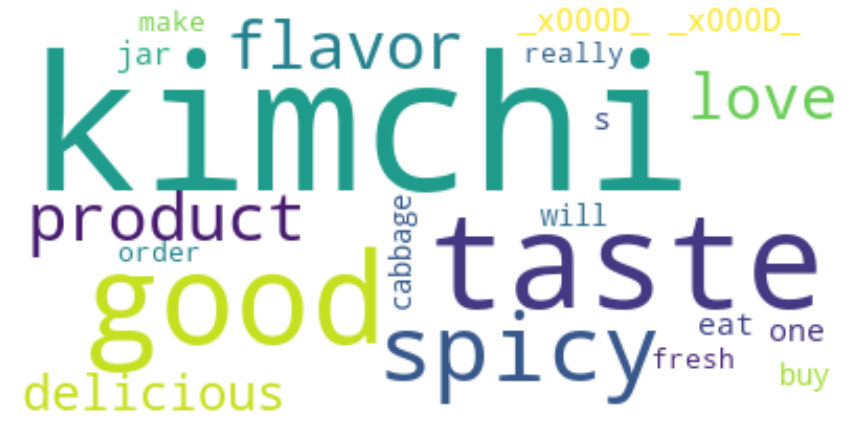

In [11]:
wc = WordCloud(background_color='white',max_words= 20, stopwords= spwords) # 스톱워드를 지정하고 20개의 주요 단어를 워드 클라우드로 출력
wordcloud = wc.generate(embed_dataset1)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [12]:
wordcloud.words_ # stopwords로 제거한 주요 단어 비중

{'kimchi': 1.0,
 'taste': 0.4211807668898357,
 'good': 0.38283627510651247,
 'spicy': 0.23189287888009738,
 'product': 0.202069385270846,
 'flavor': 0.2014607425441266,
 'love': 0.1704199634814364,
 'delicious': 0.155203895313451,
 '_x000D_ _x000D_': 0.1472915398660986,
 'jar': 0.14059646987218502,
 'eat': 0.13755325623858794,
 'one': 0.1357273280584297,
 's': 0.12720632988435787,
 'will': 0.1162507608034084,
 'cabbage': 0.11320754716981132,
 'buy': 0.10894704808277542,
 'really': 0.101034692635423,
 'make': 0.09920876445526476,
 'fresh': 0.09251369446135119,
 'order': 0.08703590992087644}

In [13]:
kimchi = nltk.Text(embed_dataset1)

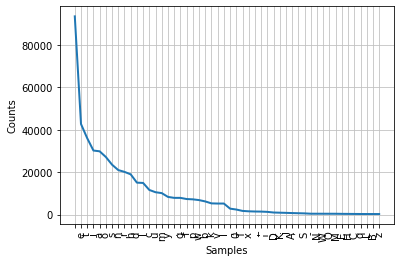

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [14]:
kimchi.plot(50)

In [15]:
embed.word2vec_train(embed_dataset,10)
# 임베딩한 단어들 학습

Epoch #0 start
Epoch #0 end
Epoch #1 start
Epoch #1 end
Epoch #2 start
Epoch #2 end
Epoch #3 start
Epoch #3 end
Epoch #4 start
Epoch #4 end
Epoch #5 start
Epoch #5 end
Epoch #6 start
Epoch #6 end
Epoch #7 start
Epoch #7 end
Epoch #8 start
Epoch #8 end
Epoch #9 start
Epoch #9 end


In [16]:
embed.word2vec.wv.most_similar('kimchi')
# kimchi(김치)에 관련된 단어들 비중

[('I’ve', 0.9895815849304199),
 ('kimchi’s', 0.987775444984436),
 ('tasted.', 0.9835953712463379),
 ("I've", 0.9788607358932495),
 ('had.', 0.977901816368103),
 ('i’ve', 0.9776979684829712),
 ('spiciest', 0.9762871265411377),
 ("i've", 0.9758620262145996),
 ('tastiest', 0.9753068089485168),
 ('best', 0.9750521779060364)]